In this task, we will model time series data using the dataset from the [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview). The original problem involves predicting daily sales for 50 products across 10 stores over a one-month period, based on 5 years of historical data. However, for the purpose of focused experimentation and time efficiency, this task is narrowed down to predicting daily sales for a single product in a single store.

Data structure:
- date - Date of the sale data. There are no holiday effects or store closures.
- store - Store ID
- item - Item ID
- sales - Number of items sold at a particular store on a particular date.

First, upload the data to Pandas.

  1. Load the data from the file `train.csv.zip` using the Pandas library.
  2. Convert the `date` column to `datetime` format.
  3. Set the `date` column as an index for the dataframe.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import darts
from darts import TimeSeries
from darts.utils.statistics import plot_acf, check_seasonality, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
path = "data/"
df = pd.read_csv(path + 'train.csv.zip', compression='zip')

df['date'] = pd.to_datetime(df['date'])
print(f'Data column type: {df['date'].dtype}')

df = df.set_index('date')
df.iloc[:10]

Data column type: datetime64[ns]


,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
2013-01-06,1,1,12
2013-01-07,1,1,10
2013-01-08,1,1,9
2013-01-09,1,1,12


# Data visualization  

We want to understand whether the dynamics for each item in the stores is different. For this we create 3 graphs to help analyze the data. 




<Figure size 2000x2000 with 0 Axes>

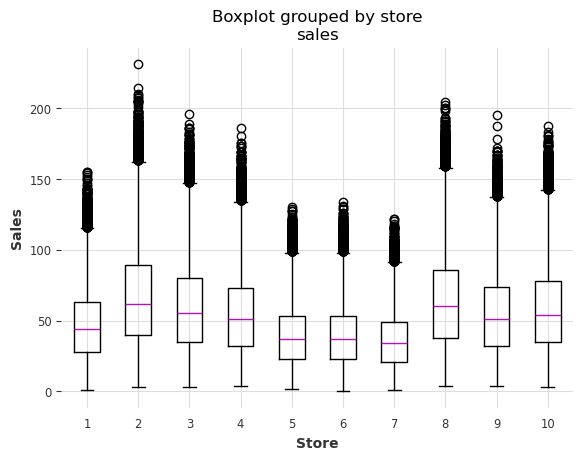

In [ ]:
# Boxplot of sales by store
plt.figure(figsize=(20, 20))
df.boxplot(column='sales', by='store')
plt.xlabel('Store')
plt.ylabel('Sales')
plt.show()

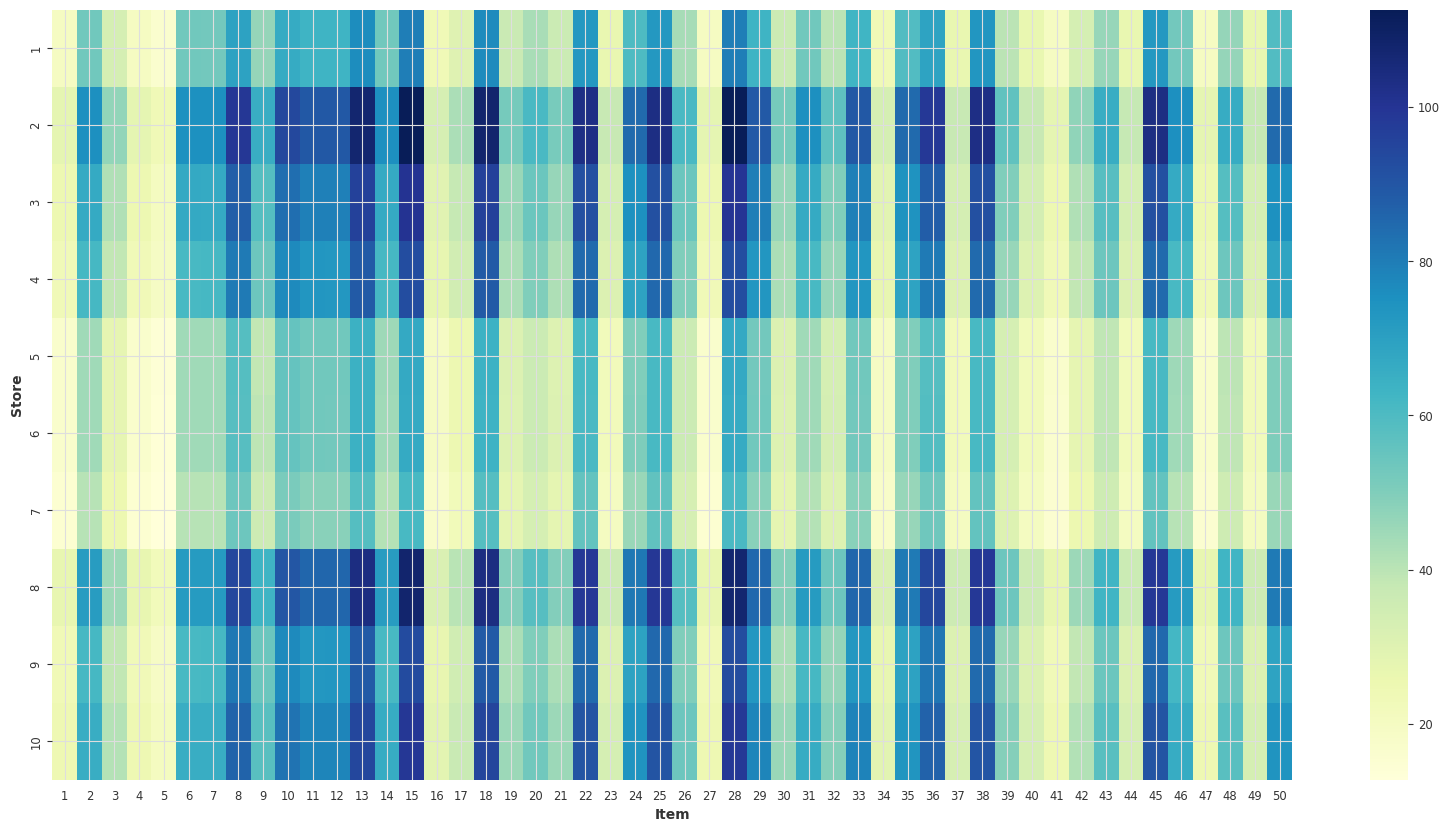

In [ ]:
#groupby store and item by mean sales and plot
mean_sales = df.groupby(['store', 'item'])['sales'].mean().reset_index()
mean_sales = mean_sales.pivot(index='store', columns='item', values='sales')
mean_sales = mean_sales.sort_values(by='store')

plt.figure(figsize=(20, 10))
sns.heatmap(mean_sales, cmap='YlGnBu')
plt.xlabel('Item')
plt.ylabel('Store')
plt.show()

In [423]:
description = df.groupby(['date', 'item']).agg(
    avg_sales=('sales', 'mean'),
    min_sales=('sales', 'min'),
    max_sales=('sales', 'max'),
    total_sales=('sales', 'sum')
).reset_index()
description


,date,item,avg_sales,min_sales,max_sales,total_sales
0,2013-01-01,1,13.3,7,20,133
1,2013-01-01,2,32.7,21,43,327
2,2013-01-01,3,17.2,9,26,172
3,2013-01-01,4,10.2,4,21,102
4,2013-01-01,5,8.3,4,13,83
...,...,...,...,...,...,...
91295,2017-12-31,46,60.5,35,79,605
91296,2017-12-31,47,21.1,12,29,211
91297,2017-12-31,48,49.4,32,64,494
91298,2017-12-31,49,28.5,12,44,285


- The heatmap shows that some stores demonstrate consistently higher sales for all products (store 8 and 2)
- We also see a tendency that certain products are more in demand in general, such as products 15, 18, 22... (vertical bars are darker).

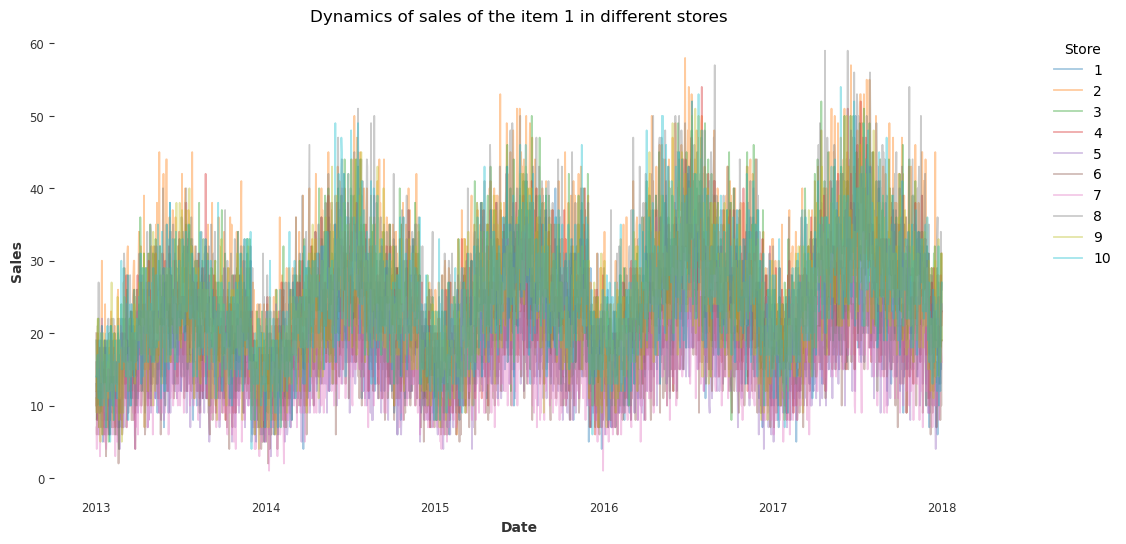

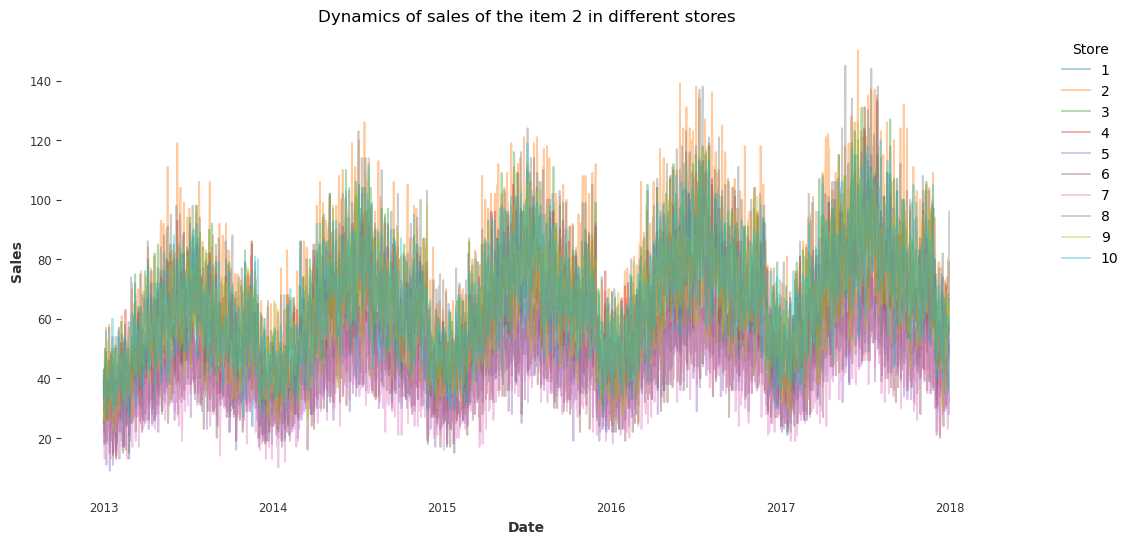

In [ ]:
# Plot the sales of the item in different stores

for item_to_plot in range(1, 3):
    df_item = df[df['item'] == item_to_plot]
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_item, x=df_item.index, y='sales', hue='store', palette='tab10', alpha=0.4) # alpha=0.4 for transparency to see overlapping lines
    plt.title(f'Dynamics of sales of the item {item_to_plot} in different stores') 
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend(title='Store', loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.grid()
    plt.show()


In [ ]:
fig = px.histogram(df, x=df.index, y='sales', title='Sales over time', marginal='box', color='store',  barmode="overlay")
fig.show()

- The graph shows a clear seasonality in sales of goods. With a peak in summer and a dip in winter.
- There is also a slight upward trend in sales over the years.
- Also, during peaks, there is a greater variability in sales across different stores for the same product, but the pattern of behavior within the same product for all stores remains similar


The general conclusion is that the products have a similar pattern of behavior between different stores, but with different amplitudes. We have no cases where the behavior of a particular product is coordinately different.

# Frequency analysis    

Let's focus on one store and one product.  
  We will select a subset of the data that corresponds to the sales of the item with `item == 1` in the store with `store == 1`.

  Decompose this row by the additive model into trend, seasonality and residuals using the `statsmodels` library.

In [4]:
df_11 = df[(df['store'] == 1) & (df['item'] == 1)]  
print(df_11.item.value_counts(), df_11.store.value_counts())
df_11.head()

item
1    1826
Name: count, dtype: int64 store
1    1826
Name: count, dtype: int64


,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


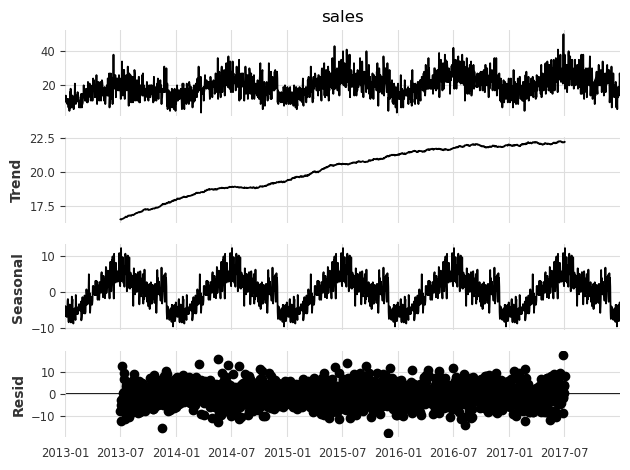

In [ ]:
# Plot the decomposed components with  period=365 for yearly seasonality
decompose_additive = seasonal_decompose(df_11['sales'], model='additive', period=365)

decompose_additive.plot()
plt.show()

- We have confirmed clear annual seasonality 
- The data trend is growing but very slowly
- Also, the residuals are randomly distributed around 0, although the error is quite significant at +-10

From the data subset created in the previous step, create an object of class `TimeSeries` in `darts` only for the column `sales`.

In [7]:
series_darts = TimeSeries.from_dataframe(df_11, value_cols='sales')
series_darts

<TimeSeries (DataArray) (date: 1826, component: 1, sample: 1)> Size: 15kB
array([[[13.]],

       [[11.]],

       [[14.]],

       ...,

       [[15.]],

       [[27.]],

       [[23.]]])
Coordinates:
  * date       (date) datetime64[ns] 15kB 2013-01-01 2013-01-02 ... 2017-12-31
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

Divide the data into training and validation so that the validation starts from `2017-10-01` inclusive.

<Axes: xlabel='date'>

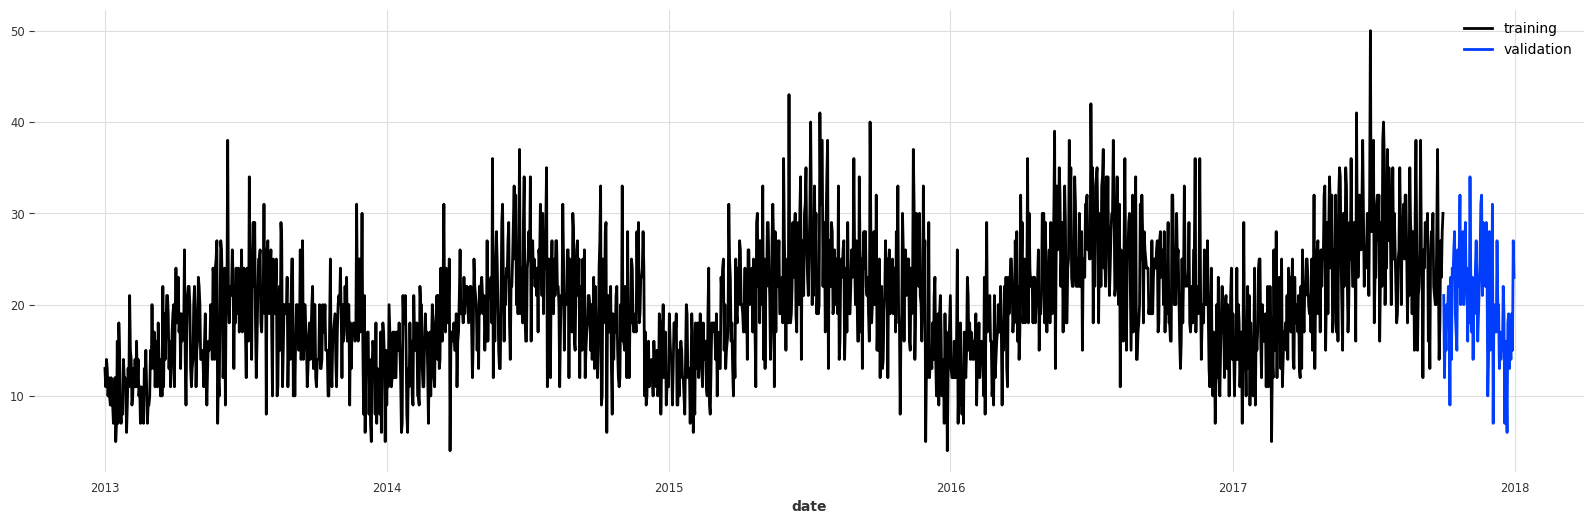

In [8]:
validation_split = '2017-10-01'
train, val = series_darts.split_before(pd.Timestamp(validation_split))

plt.figure(figsize=(20,6))
train.plot(label="training")
val.plot(label="validation")

Now let us proceed to a more detailed analysis of the time series.
Let's plot several graphs to examine global autocorrelation and more local autocorrelation

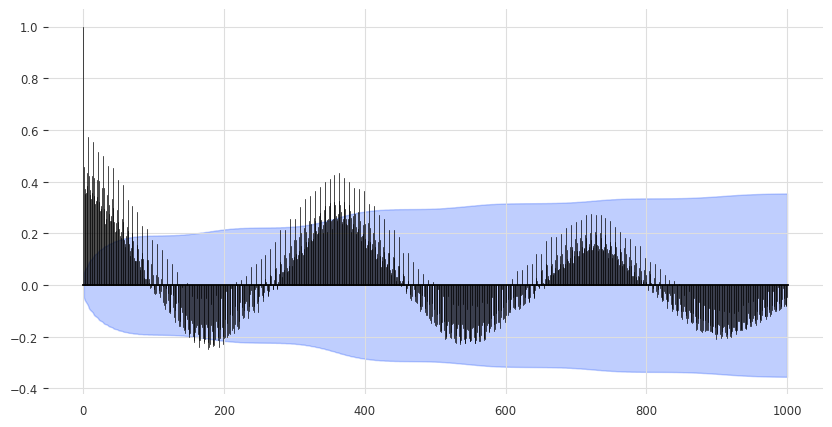

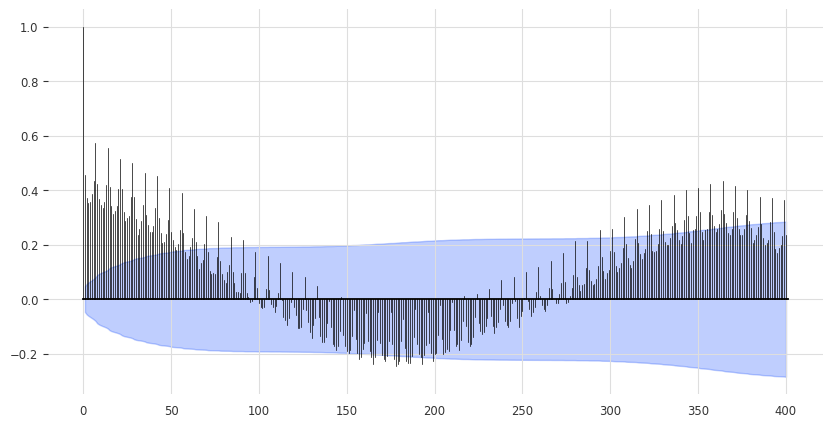

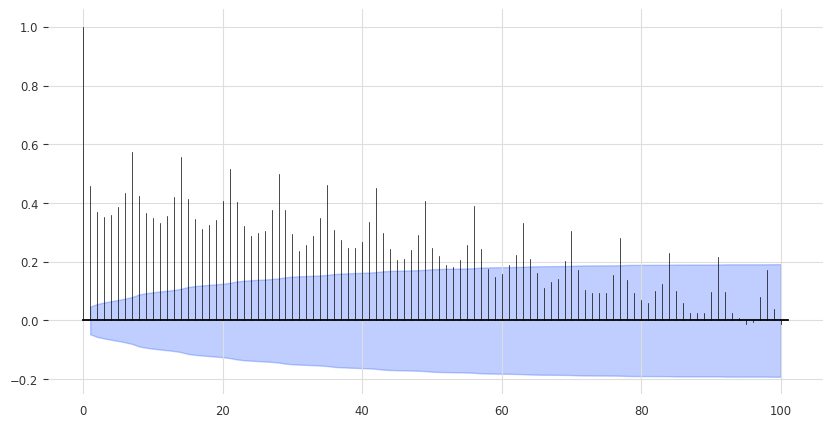

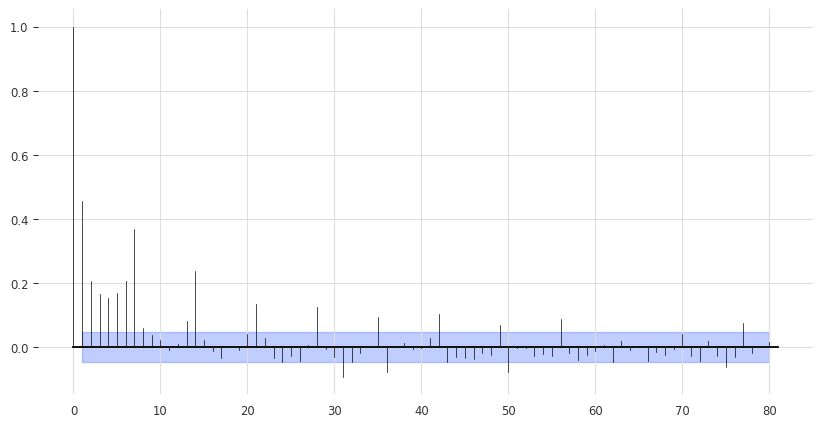

In [ ]:
# plot autocorrelation and partial autocorrelation with different lags

plot_acf(train, max_lag=1000)
plot_acf(train, max_lag=400)
plot_acf(train, max_lag=100)
plot_pacf(train, max_lag=80)

- On the widest graph, we can see a positive annual dependence of the data for about 300-400 lags
- There is also a significant negative autocorrelation between 150-200 lags. This corresponds to the six-month period when we observe a decline in our data in the previous graphs
- On a more approximate graph, we see the presence of a weekly dependence  
- Up to 50 lags, all components of the statistic are significant. At the same time, the “weekly/7-day” statistical significance remains even up to the 80th lag.
- In terms of partial autocorrelation, the first 7 lags and the next ones that are multiples of 7 are important 

Finally, we check the seasonality of the training series using the `check_seasonality` function from `darts`.

In [432]:
for m in range(2, 400):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05 , max_lag=400)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 7.
There is seasonality of order 14.
There is seasonality of order 21.
There is seasonality of order 28.
There is seasonality of order 35.
There is seasonality of order 42.
There is seasonality of order 49.
There is seasonality of order 56.
There is seasonality of order 63.
There is seasonality of order 70.
There is seasonality of order 74.
There is seasonality of order 77.
There is seasonality of order 84.
There is seasonality of order 91.
There is seasonality of order 98.
There is seasonality of order 105.
There is seasonality of order 112.
There is seasonality of order 119.
There is seasonality of order 126.
There is seasonality of order 133.
There is seasonality of order 224.
There is seasonality of order 231.
There is seasonality of order 238.
There is seasonality of order 245.
There is seasonality of order 252.
There is seasonality of order 259.
There is seasonality of order 266.
There is seasonality of order 273.
There is seasonality of order 280.
T

So we examined the available time series and saw similar behavior between different stores and products.
In addition, the data shows a frequent weekly and annual seasonality.

In the next step, we will build a model for the sales prediction 